<a href="https://colab.research.google.com/github/BlueNyang/AI_Learning_Colab/blob/main/TransferLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**A.Transfer Learning**

##**import**

In [ ]:
import numpy as np
import tensorflow as tf
import os
import pickle

from tensorflow.keras import losses
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D as GAP
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator as IDG

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image


##**default**

In [ ]:
es = EarlyStopping(monitor='val_accuracy', min_delta=0.0005, verbose=4, patience=3, mode = 'max', restore_best_weights = True)
ls = losses.categorical_crossentropy

In [ ]:
os.chdir('/content/drive/MyDrive/AI_Lecture/')

In [ ]:
def image_gen(pp_input, image_size=256):
    data_gen_with_aug = IDG(preprocessing_function = pp_input, horizontal_flip = True,
                            width_shift_range = 0.2, height_shift_range = 0.2,
                            rotation_range = 30, zoom_range = 0.2)
    data_gen_no_aug = IDG(preprocessing_function = pp_input)

    train_gen = data_gen_with_aug.flow_from_directory(
        directory = train_dir, target_size = (image_size, image_size),
        batch_size = 12, class_mode = 'categorical')

    val_gen = data_gen_no_aug.flow_from_directory(
        directory = val_dir, target_size = (image_size, image_size),
        class_mode = 'categorical')

    return train_gen, val_gen

In [ ]:
def compile_model(based_model, classes_num):
    cnn = Sequential()
    cnn.add(based_model)
    cnn.add(GAP())
    cnn.add(Dense(1024, activation = 'relu'))
    cnn.add(Dense(classes_num, activation = 'softmax'))

    cnn.compile(loss=ls, optimizer = Adam(0.0001), metrics = ['accuracy'])

    return cnn

In [ ]:
def show_hist_graph(fit_hist, fig_size = (13, 5), title='Result'):
    plt.figure(figsize=fig_size)
    plt.suptitle(title)

    plt.subplot(1,2,1)
    plt.plot(fit_hist.history['accuracy'])
    plt.plot(fit_hist.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='best')
    plt.grid()

    plt.subplot(1,2,2)
    plt.plot(fit_hist.history['loss'])
    plt.plot(fit_hist.history['val_loss'])
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='best')
    plt.grid()

    plt.show()

In [ ]:
def save_model_hist(cnn, model_name, hist):
    cnn.save(f'TransferLearning/{model_name}.h5')
    with open(f'TransferLearning/{model_name}.pkl', 'wb') as f:
        pickle.dump(hist, f)

In [ ]:
def load_model_hist(model_name):
    temp_cnn=tf.keras.models.load_model(f'TransferLearning/{model_name}.h5')
    temp_hist=pickle.load(open(f'TransferLearning/{model_name}.pkl', 'rb'))
    return temp_cnn, temp_hist

##**A.1. CUB200**

In [ ]:
train_dir = 'CUB200/train'
val_dir = 'CUB200/train'

###**A.1.1. Xception**

* **Image Generation**

In [ ]:
from tensorflow.keras.applications.xception import Xception, preprocess_input as xpre


train_generator, validation_generator = image_gen(pp_input = xpre, image_size = 256)

Found 300 images belonging to 10 classes.
Found 300 images belonging to 10 classes.


* **Xception Setting**

In [ ]:
base_model=Xception(weights='imagenet',include_top=False,input_shape=(256,256,3))

* **Model compile and train**

In [ ]:
cnn = compile_model(based_model = base_model, classes_num = 10)
hist=cnn.fit_generator(train_generator, epochs=30, validation_data=validation_generator, verbose=1, callbacks=[es])

<ipython-input-23-10beb2970880>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist=cnn.fit_generator(train_generator, epochs=30, validation_data=validation_generator, verbose=1, callbacks=[es])


Epoch 1/30
25/25 [==============================] - 38s 504ms/step - loss: 1.0980 - accuracy: 0.7700 - val_loss: 0.0871 - val_accuracy: 0.9967
Epoch 2/30
25/25 [==============================] - 12s 498ms/step - loss: 0.2336 - accuracy: 0.9633 - val_loss: 0.0117 - val_accuracy: 1.0000
Epoch 3/30
25/25 [==============================] - 11s 430ms/step - loss: 0.1168 - accuracy: 0.9800 - val_loss: 0.0104 - val_accuracy: 1.0000
Epoch 4/30
25/25 [==============================] - 12s 471ms/step - loss: 0.1052 - accuracy: 0.9700 - val_loss: 0.0050 - val_accuracy: 1.0000
Epoch 5/30
25/25 [==============================] - 11s 456ms/step - loss: 0.0715 - accuracy: 0.9800 - val_loss: 0.0231 - val_accuracy: 0.9900
Epoch 5: early stopping


* **Assessment**

In [ ]:
res=cnn.evaluate(validation_generator, verbose=1)
print(f"Accuracy is {res[1]*100}%")

10/10 [==============================] - 3s 263ms/step - loss: 0.0117 - accuracy: 1.0000
Accuracy is 100.0%


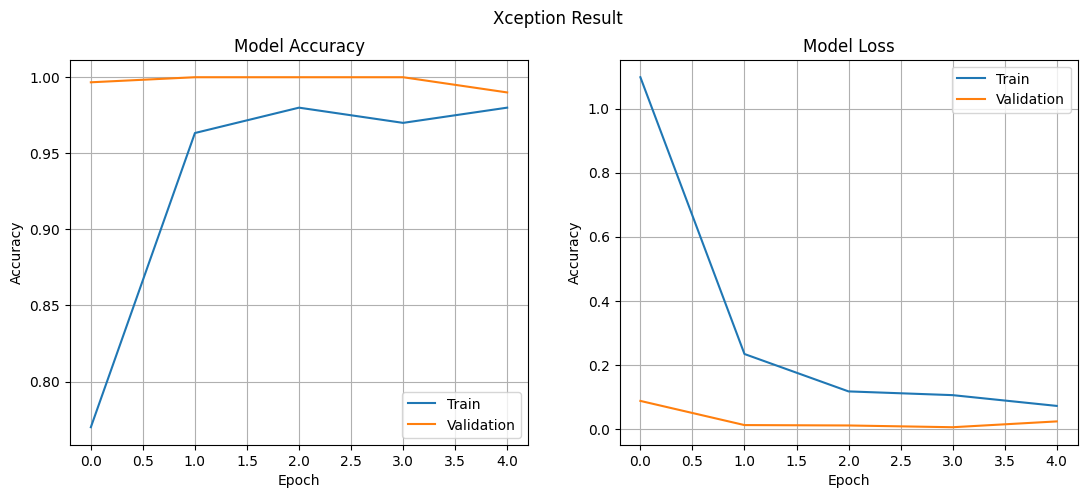

In [ ]:
show_hist_graph(fit_hist = hist, fig_size = (13, 5), title = "Xception - CUB200")

 * **Save**

In [ ]:
save_model_hist(cnn, 'cub200_xception', hist)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


* **Load and test**

In [ ]:
cnn_xception, hist_xception = load_model_hist('cub200_xception')
cnn.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 8, 8, 2048)        20861480  
                                                                 
 global_average_pooling2d_2  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_6 (Dense)             (None, 1024)              2098176   
                                                                 
 dense_7 (Dense)             (None, 10)                10250     
                                                                 
Total params: 22969906 (87.62 MB)
Trainable params: 22915378 (87.42 MB)
Non-trainable params: 54528 (213.00 KB)
_________________________________________________________________


In [ ]:
res=cnn_xception.evaluate(validation_generator, verbose=1)
print(f"Accuracy is {res[1]*100}%")

10/10 [==============================] - 3s 245ms/step - loss: 0.0078 - accuracy: 0.9967
Accuracy is 99.6666669845581%


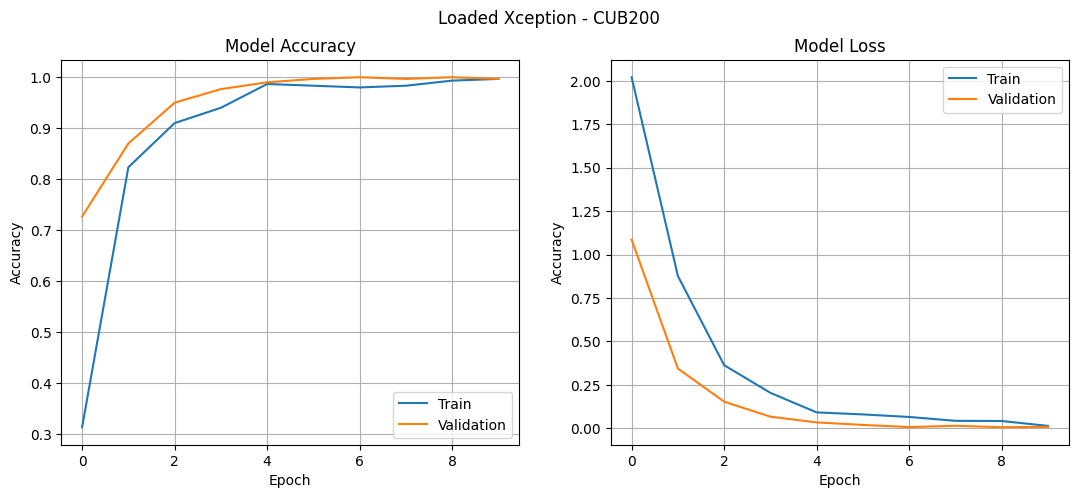

In [ ]:
show_hist_graph(fit_hist = hist_xception, fig_size = (13,5), title = 'Loaded Xception - CUB200')

###**A.1.2. Res50**

* **Image Genaration**

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input as r50pre

train_generator, validation_generator = image_gen(pp_input = r50pre, image_size = 256)

Found 300 images belonging to 10 classes.
Found 300 images belonging to 10 classes.


* **ResNet 50 Setting**

In [ ]:
base_model=ResNet50(weights='imagenet',include_top=False,input_shape=(256,256,3))

94765736/94765736 [==============================] - 3s 0us/step


* **Model compile and Training**

In [ ]:
cnn = compile_model(based_model = base_model, classes_num = 10)
hist=cnn.fit_generator(train_generator, epochs=30, validation_data=validation_generator, verbose=1, callbacks=[es])

<ipython-input-39-10beb2970880>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist=cnn.fit_generator(train_generator, epochs=30, validation_data=validation_generator, verbose=1, callbacks=[es])


Epoch 1/30
25/25 [==============================] - 95s 826ms/step - loss: 1.6879 - accuracy: 0.4733 - val_loss: 0.5519 - val_accuracy: 0.8100
Epoch 2/30
25/25 [==============================] - 11s 450ms/step - loss: 0.5055 - accuracy: 0.8333 - val_loss: 0.3417 - val_accuracy: 0.8900
Epoch 3/30
25/25 [==============================] - 13s 505ms/step - loss: 0.2169 - accuracy: 0.9333 - val_loss: 0.0942 - val_accuracy: 0.9800
Epoch 4/30
25/25 [==============================] - 10s 404ms/step - loss: 0.1431 - accuracy: 0.9633 - val_loss: 0.0624 - val_accuracy: 0.9900
Epoch 5/30
25/25 [==============================] - 10s 412ms/step - loss: 0.0945 - accuracy: 0.9733 - val_loss: 0.0229 - val_accuracy: 0.9900
Epoch 6/30
25/25 [==============================] - 11s 456ms/step - loss: 0.1497 - accuracy: 0.9633 - val_loss: 0.0722 - val_accuracy: 0.9800
Epoch 7/30
25/25 [==============================] - 11s 452ms/step - loss: 0.1302 - accuracy: 0.9533 - val_loss: 0.1104 - val_accuracy: 0.9567

* **Assessment**

In [ ]:
res=cnn.evaluate(validation_generator, verbose=1)
print(f"Accuracy is {res[1]*100}%")

10/10 [==============================] - 3s 231ms/step - loss: 0.0624 - accuracy: 0.9900
Accuracy is 99.00000095367432%


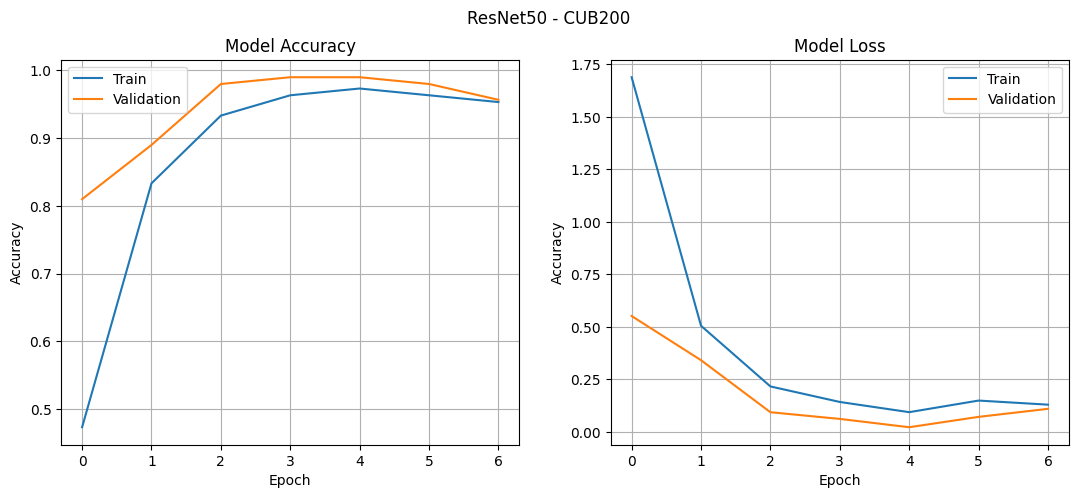

In [ ]:
show_hist_graph(fit_hist = hist, fig_size = (13, 5), title = 'ResNet50 - CUB200')

* **Save**

In [ ]:
save_model_hist(cnn, 'cub200_resnet50', hist)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


* **Load and Test**

In [ ]:
cnn_resnet50, hist_resnet50 = load_model_hist('cub200_resnet50')
cnn_resnet50.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 global_average_pooling2d_4  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_8 (Dense)             (None, 1024)              2098176   
                                                                 
 dense_9 (Dense)             (None, 10)                10250     
                                                                 
Total params: 25696138 (98.02 MB)
Trainable params: 25643018 (97.82 MB)
Non-trainable params: 53120 (207.50 KB)
_________________________________________________________________


In [ ]:
res=cnn_resnet50.evaluate(validation_generator, verbose=1)
print(f"Accuracy is {res[1]*100}%")

10/10 [==============================] - 3s 224ms/step - loss: 0.0624 - accuracy: 0.9900
Accuracy is 99.00000095367432%


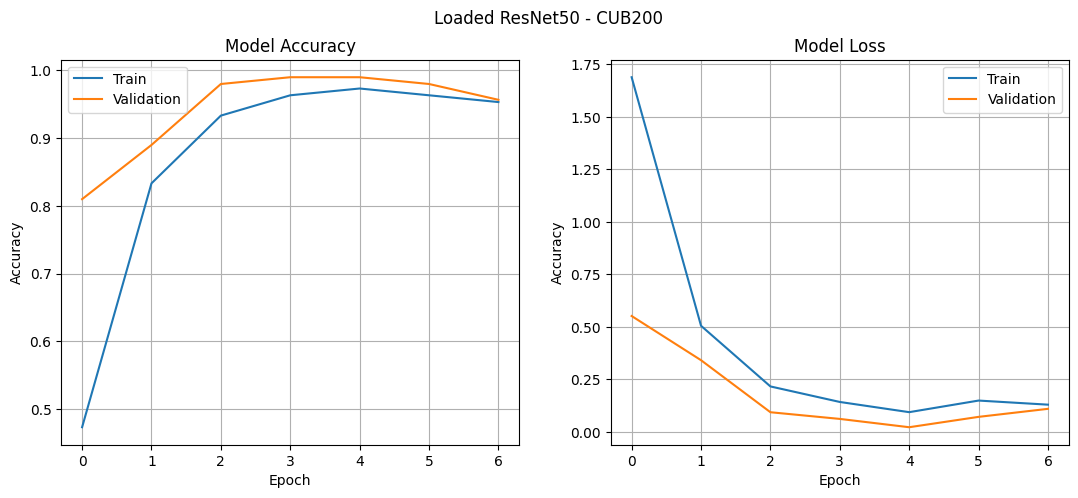

In [ ]:
show_hist_graph(fit_hist = hist_resnet50, fig_size = (13,5), title = 'Loaded ResNet50 - CUB200')

###**A.1.3. ResNet152 V2**

* **Image Generation**

In [ ]:
from tensorflow.keras.applications.resnet_v2 import ResNet152V2, preprocess_input as r152v2pre

train_generator, validation_generator = image_gen(pp_input = r152v2pre, image_size = 256)

Found 300 images belonging to 10 classes.
Found 300 images belonging to 10 classes.


* **ResNet152 V2 Setting**

In [ ]:
base_model=ResNet152V2(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

234545216/234545216 [==============================] - 6s 0us/step


* **Compile and Training**

In [ ]:
cnn = compile_model(based_model = base_model, classes_num = 10)
hist=cnn.fit_generator(train_generator, epochs=30, validation_data=validation_generator, verbose=1, callbacks=[es])

<ipython-input-54-10beb2970880>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist=cnn.fit_generator(train_generator, epochs=30, validation_data=validation_generator, verbose=1, callbacks=[es])


Epoch 1/30
25/25 [==============================] - 228s 2s/step - loss: 1.7539 - accuracy: 0.4133 - val_loss: 0.4161 - val_accuracy: 0.8800
Epoch 2/30
25/25 [==============================] - 18s 722ms/step - loss: 0.5849 - accuracy: 0.8567 - val_loss: 0.3996 - val_accuracy: 0.8600
Epoch 3/30
25/25 [==============================] - 17s 680ms/step - loss: 0.3265 - accuracy: 0.9067 - val_loss: 0.0908 - val_accuracy: 0.9667
Epoch 4/30
25/25 [==============================] - 16s 638ms/step - loss: 0.1908 - accuracy: 0.9433 - val_loss: 0.0946 - val_accuracy: 0.9700
Epoch 5/30
25/25 [==============================] - 14s 563ms/step - loss: 0.2274 - accuracy: 0.9400 - val_loss: 0.0915 - val_accuracy: 0.9733
Epoch 6/30
25/25 [==============================] - 14s 548ms/step - loss: 0.2626 - accuracy: 0.9100 - val_loss: 0.3292 - val_accuracy: 0.8933
Epoch 7/30
25/25 [==============================] - 14s 567ms/step - loss: 0.1758 - accuracy: 0.9467 - val_loss: 0.1833 - val_accuracy: 0.9433
E

* **Assessment**

In [ ]:
res=cnn.evaluate(validation_generator, verbose=1)
print(f"Accuracy is {res[1]*100}%")

10/10 [==============================] - 3s 239ms/step - loss: 0.0278 - accuracy: 0.9967
Accuracy is 99.6666669845581%


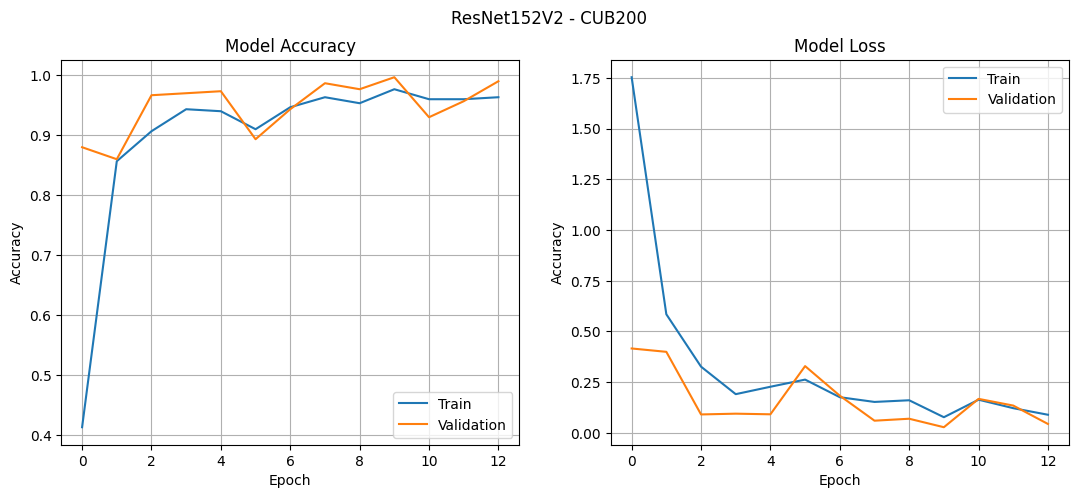

In [ ]:
show_hist_graph(fit_hist = hist, fig_size = (13, 5), title = 'ResNet152V2 - CUB200')

* **Save**

In [ ]:
save_model_hist(cnn, 'cub200_resnet152v2', hist)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


* **Load and Test**

In [ ]:
cnn_resnet152v2, hist_resnet152v2 = load_model_hist('cub200_resnet152v2')
cnn_resnet152v2.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152v2 (Functional)    (None, 8, 8, 2048)        58331648  
                                                                 
 global_average_pooling2d_6  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_12 (Dense)            (None, 1024)              2098176   
                                                                 
 dense_13 (Dense)            (None, 10)                10250     
                                                                 
Total params: 60440074 (230.56 MB)
Trainable params: 60296330 (230.01 MB)
Non-trainable params: 143744 (561.50 KB)
_________________________________________________________________


In [ ]:
res=cnn_resnet152v2.evaluate(validation_generator, verbose=1)
print(f"Accuracy is {res[1]*100}%")

10/10 [==============================] - 6s 249ms/step - loss: 0.0278 - accuracy: 0.9967
Accuracy is 99.6666669845581%


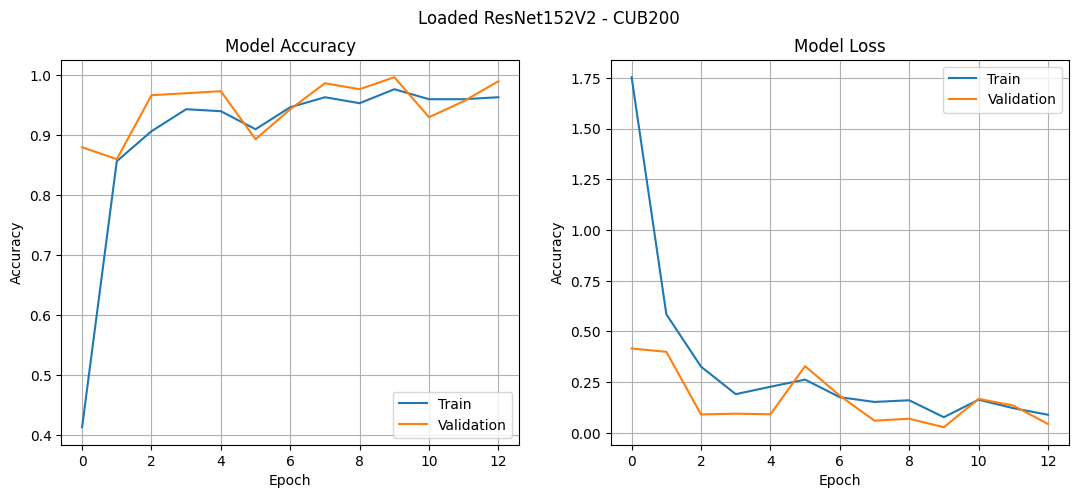

In [ ]:
show_hist_graph(fit_hist = hist_resnet152v2, fig_size = (13, 5), title = 'Loaded ResNet152V2 - CUB200')